In [35]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial import ConvexHull
from matplotlib.path import Path as MplPath
from scipy.interpolate import griddata
from matplotlib.colors import Normalize



In [22]:
def interp_depth(lons_src, lats_src, depths_src, lons_q, lats_q):
    """Linear griddata with nearest fallback."""
    zi = griddata((lons_src, lats_src), depths_src, (lons_q, lats_q), method="linear")
    if np.isnan(zi).any():
        zin = griddata((lons_src, lats_src), depths_src, (lons_q, lats_q), method="nearest")
        zi[np.isnan(zi)] = zin[np.isnan(zi)]
    return zi
def hull_path(lon, lat):
    """Convex-hull polygon Path for a set of (lon,lat) nodes."""
    pts = np.column_stack([np.ravel(lon), np.ravel(lat)])
    pts = pts[np.isfinite(pts).all(axis=1)]
    hull = ConvexHull(pts)
    poly = pts[hull.vertices]
    return MplPath(poly)

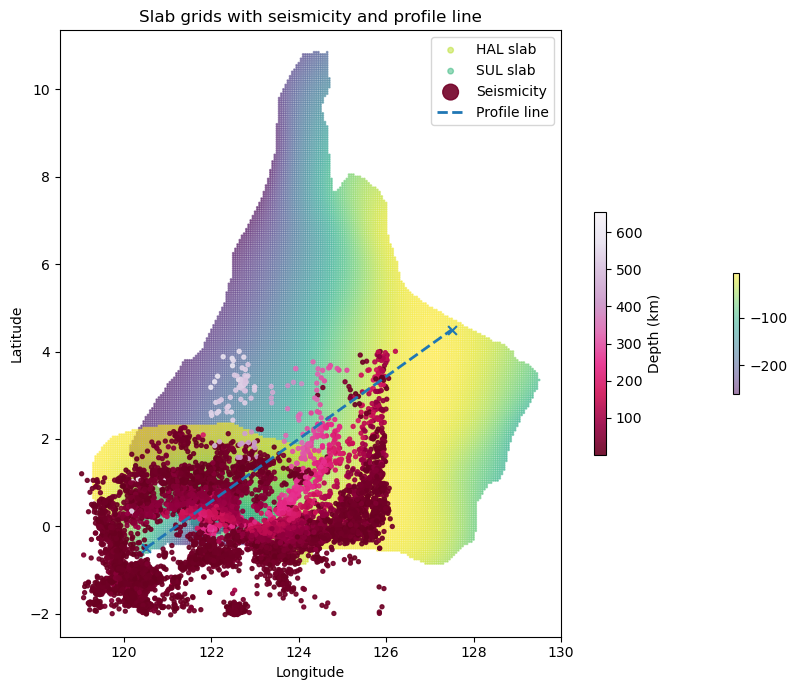

In [39]:

hal = np.loadtxt("hal_slab2_dep_02.23.18.xyz")
sul = np.loadtxt("sul_slab2_dep_02.23.18.xyz")
hal_lon, hal_lat, hal_z = hal[:,0], hal[:,1], hal[:,2]
sul_lon, sul_lat, sul_z = sul[:,0], sul[:,1], sul[:,2]

eq_df = pd.read_csv("Reloc_jan.csv")

lon_col = None
lat_col = None
depth_col = None


lon_col = "Longitude"
lat_col = "Latitude"

depth_col = "Depth"

if lon_col is None or lat_col is None:
    raise ValueError("Could not detect longitude/latitude columns in Reloc_jan.csv")

eq = eq_df[[lon_col, lat_col] + ([depth_col] if depth_col else [])].dropna()

lon1, lat1 = 120.5, -0.5   # start
lon2, lat2 = 127.5, 4.5    # end

plt.figure(figsize=(9,7))

plt.scatter(hal_lon, hal_lat, c=hal_z, s=1, alpha=0.5, label="HAL slab")
plt.scatter(sul_lon, sul_lat, c=sul_z, s=1, alpha=0.5, label="SUL slab")
plt.colorbar(shrink=0.2)
if depth_col:
    sc = plt.scatter(eq[lon_col], eq[lat_col], c=eq[depth_col], s=8, alpha=0.9, label="Seismicity",cmap='PuRd_r')
    cbar = plt.colorbar(sc,shrink=0.4)
    cbar.set_label(f"{depth_col} (km)")
else:
    plt.scatter(eq[lon_col], eq[lat_col], s=8, alpha=0.9, label="Seismicity",c='red')

plt.plot([lon1, lon2], [lat1, lat2], linestyle="--", linewidth=2, label="Profile line")
plt.scatter([lon1, lon2], [lat1, lat2], s=40, marker="x")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Slab grids with seismicity and profile line")
plt.legend(markerscale=4)
plt.gca().set_aspect("equal", adjustable="box")


pad = 0.5
xmin = min(hal_lon.min(), sul_lon.min(), eq[lon_col].min()) - pad
xmax = max(hal_lon.max(), sul_lon.max(), eq[lon_col].max()) + pad
ymin = min(hal_lat.min(), sul_lat.min(), eq[lat_col].min()) - pad
ymax = max(hal_lat.max(), sul_lat.max(), eq[lat_col].max()) + pad
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.tight_layout()



In [40]:


hal_depth_km = -hal_z
sul_depth_km = -sul_z

hal_fp = hull_path(hal_lon, hal_lat)
sul_fp = hull_path(sul_lon, sul_lat)



eq = eq_df.copy()
for c in [lon_col, lat_col, depth_col]:
    eq[c] = pd.to_numeric(eq[c], errors="coerce")
eq = eq.dropna(subset=[lon_col, lat_col, depth_col]).reset_index(drop=True)

pts = eq[[lon_col, lat_col]].values
in_hal = hal_fp.contains_points(pts, radius=1e-9)
in_sul = sul_fp.contains_points(pts, radius=1e-9)
in_footprint = in_hal | in_sul

eq = eq.loc[in_footprint].reset_index(drop=True)

eq["slab_HAL_km"] = interp_depth(hal_lon, hal_lat, hal_depth_km, eq[lon_col].values, eq[lat_col].values)
eq["slab_SUL_km"] = interp_depth(sul_lon, sul_lat, sul_depth_km, eq[lon_col].values, eq[lat_col].values)

lo_off, hi_off = -10.0, 60.0  # km
eq["within_HAL"] = (eq[depth_col] >= eq["slab_HAL_km"] + lo_off) & (eq[depth_col] <= eq["slab_HAL_km"] + hi_off)
eq["within_SUL"] = (eq[depth_col] >= eq["slab_SUL_km"] + lo_off) & (eq[depth_col] <= eq["slab_SUL_km"] + hi_off)

eq["delta_HAL_km"] = eq[depth_col] - eq["slab_HAL_km"]
eq["delta_SUL_km"] = eq[depth_col] - eq["slab_SUL_km"]

cols_out = list(eq_df.columns) + ["slab_HAL_km","delta_HAL_km","within_HAL","slab_SUL_km","delta_SUL_km","within_SUL"]
eq_out = eq.reindex(columns=cols_out)

hal_filtered = eq_out[eq_out["within_HAL"]].copy()
sul_filtered = eq_out[eq_out["within_SUL"]].copy()

hal_path = Path("eq_filtered_HAL.csv")
sul_path = Path("eq_filtered_SUL.csv")
eq_path  = Path("eq_with_slab_depths.csv")

hal_filtered.to_csv(hal_path, index=False)
sul_filtered.to_csv(sul_path, index=False)
eq_out.to_csv(eq_path, index=False)

summary = pd.DataFrame({
    "Set": ["All EQ (after footprint filter)", "HAL window", "SUL window", "Both windows"],
    "Count": [
        len(eq_out),
        len(hal_filtered),
        len(sul_filtered),
        len(eq_out[eq_out["within_HAL"] & eq_out["within_SUL"]]),
    ]
})

print(summary)


                               Set  Count
0  All EQ (after footprint filter)   8779
1                       HAL window   1577
2                       SUL window   2849
3                     Both windows    948


In [41]:


lon1, lat1 = 120.5, -0.5   # start
lon2, lat2 = 127.5,  4.5   # end
n_profile = 300
corridor_km = 50.0

def local_xy(lon, lat, lon0, lat0):
    R = 111.0  # km per deg lat
    x = (lon - lon0) * R * np.cos(np.deg2rad(lat0))
    y = (lat - lat0) * R
    return x, y

def inv_local_xy(x, y, lon0, lat0):
    R = 111.0
    lon = lon0 + x / (R * np.cos(np.deg2rad(lat0)))
    lat = lat0 + y / R
    return lon, lat

lons = np.linspace(lon1, lon2, n_profile)
lats = np.linspace(lat1, lat2, n_profile)
lon0 = (lon1 + lon2) / 2.0
lat0 = (lat1 + lat2) / 2.0
x_prof, y_prof = local_xy(lons, lats, lon0, lat0)

dx = np.gradient(x_prof); dy = np.gradient(y_prof)
seglen = np.hypot(dx, dy); seglen[seglen == 0] = 1.0
tx, ty = dx/seglen, dy/seglen
nx, ny = -ty, tx

x_left  = x_prof + corridor_km * nx
y_left  = y_prof + corridor_km * ny
x_right = x_prof - corridor_km * nx
y_right = y_prof - corridor_km * ny

poly_x = np.concatenate([x_left,  x_right[::-1]])
poly_y = np.concatenate([y_left,  y_right[::-1]])
poly_lon, poly_lat = inv_local_xy(poly_x, poly_y, lon0, lat0)

hal_prof = interp_depth(hal_lon, hal_lat, hal_depth_km, lons, lats)
sul_prof = interp_depth(sul_lon, sul_lat, sul_depth_km, lons, lats)

dist_prof = np.zeros(n_profile)
for i in range(1, n_profile):
    dist_prof[i] = dist_prof[i-1] + np.hypot(x_prof[i]-x_prof[i-1], y_prof[i]-y_prof[i-1])

eq_x, eq_y = local_xy(eq[lon_col].values, eq[lat_col].values, lon0, lat0)

Lx, Ly = x_prof[-1] - x_prof[0], y_prof[-1] - y_prof[0]
L2 = Lx*Lx + Ly*Ly
t = ((eq_x - x_prof[0]) * Lx + (eq_y - y_prof[0]) * Ly) / L2
t = np.clip(t, 0.0, 1.0)
cx = x_prof[0] + t * Lx
cy = y_prof[0] + t * Ly
dist_perp = np.hypot(eq_x - cx, eq_y - cy)             # km, perpendicular
dist_along = t * dist_prof[-1]                          # km, along-track

mask_corr = dist_perp <= corridor_km

# Corridor + slab-window subsets (HAL & SUL)
hal_corr = eq.loc[mask_corr & eq["within_HAL"]].copy()
sul_corr = eq.loc[mask_corr & eq["within_SUL"]].copy()
hal_corr["dist_km"] = dist_along[mask_corr & eq["within_HAL"]]
sul_corr["dist_km"] = dist_along[mask_corr & eq["within_SUL"]]


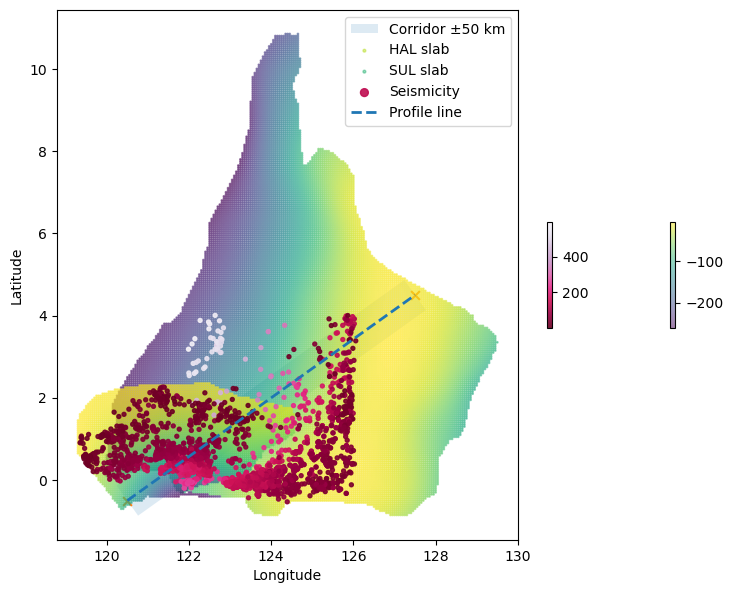

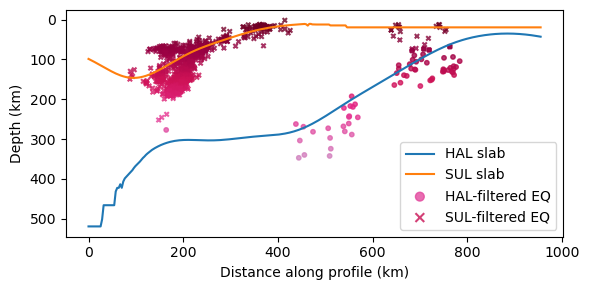

In [42]:
depth_hal = np.asarray(hal_filtered["Depth"], dtype=float)
depth_sul = np.asarray(sul_filtered["Depth"], dtype=float)
depth_all = np.concatenate([depth_hal[np.isfinite(depth_hal)],
                            depth_sul[np.isfinite(depth_sul)]])

vmin, vmax = float(np.min(depth_all)), float(np.max(depth_all))
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("PuRd_r")

plt.figure(figsize=(8,6))
plt.fill(poly_lon, poly_lat, alpha=0.15, label=f"Corridor ±{corridor_km:.0f} km")
plt.scatter([lon1, lon2], [lat1, lat2], s=40, marker="x")


plt.scatter(hal_lon, hal_lat, c=hal_z, s=1, alpha=0.5, label="HAL slab")
plt.scatter(sul_lon, sul_lat, c=sul_z, s=1, alpha=0.5, label="SUL slab")
plt.colorbar(shrink=0.2)
if depth_col:

    sc = plt.scatter(hal_filtered['Longitude'], hal_filtered['Latitude'], c=hal_filtered['Depth'], s=8, alpha=0.9, cmap=cmap, norm=norm)
    sc = plt.scatter(sul_filtered['Longitude'], sul_filtered['Latitude'], c=sul_filtered['Depth'], s=8, alpha=0.9, label="Seismicity", cmap=cmap, norm=norm)
    plt.colorbar(sc,shrink=0.2)
else:
    plt.scatter(eq[lon_col], eq[lat_col], s=8, alpha=0.9, label="Seismicity",c='red')

plt.plot([lon1, lon2], [lat1, lat2], linestyle="--", linewidth=2, label="Profile line")

plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.gca().set_aspect("equal", adjustable="box")
plt.legend(markerscale=2)
plt.tight_layout()

plt.figure(figsize=(6,3))
plt.plot(dist_prof, hal_prof, label="HAL slab")
plt.plot(dist_prof, sul_prof, label="SUL slab")
plt.scatter(hal_corr["dist_km"], hal_corr[depth_col],c= hal_corr[depth_col], s=10,cmap=cmap, norm=norm, marker="o", alpha=0.8, label="HAL-filtered EQ")
plt.scatter(sul_corr["dist_km"], sul_corr[depth_col], c= sul_corr[depth_col],s=10,cmap=cmap, norm=norm, marker="x", alpha=0.8, label="SUL-filtered EQ")
plt.gca().invert_yaxis()
plt.xlabel("Distance along profile (km)"); plt.ylabel("Depth (km)")
plt.legend(markerscale=2)
plt.tight_layout()
